In [1]:
import pickle
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset
from torch_geometric.data import Data
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
class Customized_Dataset(Dataset):
    def __init__(self, metadata):
        super(Customized_Dataset, self).__init__()
        self.data = pickle.load(open(metadata, 'rb'))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        with torch.no_grad():
            text_embed = self.data[idx]['text_embed']
            audio_embed = self.data[idx]['audio_embed']
            label = self.data[idx]['label']

        return text_embed, audio_embed, label

In [3]:
BATCH_SIZE = 128
train_metadata = "C:/Users/admin/Documents/Speech-Emotion_Recognition-2/features/IEMOCAP_BERT_ECAPA_train.pkl"
val_metadata = "C:/Users/admin/Documents/Speech-Emotion_Recognition-2/features/IEMOCAP_BERT_ECAPA_val.pkl"
test_metadata = "C:/Users/admin/Documents/Speech-Emotion_Recognition-2/features/IEMOCAP_BERT_ECAPA_test.pkl"
train_dataset = Customized_Dataset(train_metadata)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = Customized_Dataset(val_metadata)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
import torch.nn.functional as F
class FlexibleMMSER(nn.Module, ):
    def __init__(self, 
                 text_embed_dim=480,  
                 audio_embed_dim=480, 
                 num_classes=4, 
                 dropout_rate=0.3):
        super(FlexibleMMSER, self).__init__()
        
        concat_embed_dim = text_embed_dim + audio_embed_dim
        
        self.projection = nn.Sequential(
            nn.Linear(concat_embed_dim, 960), 
            nn.BatchNorm1d(960),
            nn.GELU()
        )
        
        self.dropout = nn.Dropout(dropout_rate)
        self.linear1 = nn.Linear(960, 256)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, text_embed, audio_embed):
        concat_embed = torch.cat((text_embed, audio_embed), dim=1)
        
        projected_embed = self.projection(concat_embed)
        
        x = self.dropout(projected_embed)

        x = F.gelu(self.linear1(x))
        x = F.gelu(self.linear2(x))
        y_logits = self.linear3(x)
        y_softmax = self.softmax(y_logits)
        
        return y_logits, y_softmax

class DiagnosticMMSER(FlexibleMMSER):
    def diagnose_embeddings(self, text_embed, audio_embed):
        """
        Diagnostic method to understand embedding characteristics
        """
        print(f"Text Embedding Shape: {text_embed.shape}")
        print(f"Audio Embedding Shape: {audio_embed.shape}")
        
        concat_embed = torch.cat((text_embed, audio_embed), dim=1)
        print(f"Concatenated Embedding Shape: {concat_embed.shape}")
        
        return concat_embed

In [17]:
def calculate_accuracy(y_pred, y_true):
    class_weights = {cls: 1.0/count for cls, count in Counter(y_true).items()}
    wa = balanced_accuracy_score(y_true, y_pred, sample_weight=[class_weights[cls] for cls in y_true])
    ua = accuracy_score(y_true, y_pred)
    return wa, ua

In [18]:
def train_step(model, dataloader, optim, loss_fn, accuracy_fn):
    train_loss = 0.0
    train_wa = 0.0
    train_ua = 0.0
    y_true_ls = []
    y_pred_ls = []
    
    model.train()
    for batch, (text_embed, audio_embed, label) in enumerate(dataloader):
        text_embed = text_embed.to(device)
        audio_embed = audio_embed.to(device)
        label = label.to(device)
        output_logits, output_softmax = model(text_embed, audio_embed)
        output_logits, output_softmax = output_logits.to(device), output_softmax.to(device)
        y_preds = output_softmax.argmax(dim=1).to(device)
        
        wa, ua = calculate_accuracy(y_preds.cpu().numpy(), label.cpu().numpy())
        y_true_ls.append(label.cpu().numpy())
        y_pred_ls.append(y_preds.cpu().numpy())
        loss = loss_fn(output_logits, label)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        train_loss += loss.item()
        train_wa += wa
        train_ua += ua
        
        # if batch % 20 == 0:
        #     print(f"\tBatch {batch}: Train loss: {loss:.5f} | Train WA : {wa:.4f} | Train UA : {ua:.4f}")
        #     print("----------------------------------------")
        
    train_loss /= len(dataloader)
    train_wa /= len(dataloader)
    train_ua /= len(dataloader)
    print(f"Total Train loss: {train_loss:.5f} | Total Train WA : {wa:.4f} | Total Train UA : {ua:.4f}")
    
    return train_loss, train_wa, train_ua, y_true_ls, y_pred_ls

In [19]:
def eval_step(model, dataloader, loss_fn, accuracy_fn):
    eval_loss = 0.0
    eval_wa = 0.0
    eval_ua = 0.0
    y_true_ls = []
    y_pred_ls = []
    
    model.eval()
    with torch.no_grad():
        for batch, (text_embed, audio_embed, label) in enumerate(dataloader):
            text_embed = text_embed.to(device)
            audio_embed = audio_embed.to(device)
            label = label.to(device)
            output_logits, output_softmax = model(text_embed, audio_embed)
            output_logits, output_softmax = output_logits.to(device), output_softmax.to(device)
            y_preds = output_softmax.argmax(dim=1).to(device)
            
            wa, ua = calculate_accuracy(y_preds.cpu().numpy(), label.cpu().numpy())
            y_true_ls.append(label.cpu().numpy())
            y_pred_ls.append(y_preds.cpu().numpy())
            loss = loss_fn(output_logits, label)

            eval_loss += loss.item()
            eval_wa += wa
            eval_ua += ua

            # if batch % 20 == 0:
            #     print(f"\tBatch {batch}: Test loss: {loss:.5f} | Test WA : {wa:.4f} | Test UA : {ua:.4f}")
            #     print("----------------------------------------")
        
        eval_loss /= len(dataloader)
        eval_wa /= len(dataloader)
        eval_ua /= len(dataloader)
        print(f"Total Test loss: {eval_loss:.5f} | Total Test WA: {eval_wa:.4f} | Total Test UA: {eval_ua:4f}")
        
        return eval_loss, eval_wa, eval_ua, y_true_ls, y_pred_ls

In [20]:
epochs = []
train_loss_hist, train_wa_hist, train_ua_hist, val_loss_hist, val_wa_hist, val_ua_hist = [], [], [], [], [], []

best_w = {}

best_train_loss, best_val_loss = 10000, 10000
best_wa, best_ua = 0.0, 0.0

NUM_EPOCHS = 200

model=DiagnosticMMSER(num_classes=4)
model.to(device)

optimizer = optim.Adam(params=model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [21]:
# Train Multi-modal model
for epoch in range(NUM_EPOCHS):
    print("Epoch", epoch)
    train_loss, train_wa, train_ua, y_true_ls, y_pred_ls = train_step(model, train_dataloader, optimizer, criterion, calculate_accuracy)
    val_loss, val_wa, val_ua, y_true_ls, y_pred_ls = eval_step(model, val_dataloader, criterion, calculate_accuracy)
    lr_scheduler.step()
    
    epochs.append(epoch)
    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_wa_hist.append(train_wa*100)
    val_wa_hist.append(val_wa*100)
    train_ua_hist.append(train_ua*100)
    val_ua_hist.append(val_ua*100)
    
    if train_loss < best_train_loss and val_loss < best_val_loss:
        best_train_loss, best_val_loss = train_loss, val_loss
        best_wa, best_ua = val_wa, val_ua
        torch.save(model.state_dict(), "C:/Users/admin/Documents/Speech-Emotion_Recognition-2/saved_models/IEMOCAP_ENG_CMN_BERT_ECAPA.pt")
        best_w = model.state_dict()
    
    print("\n==============================\n")
print("Best WA: ", best_wa)
print("Best UA: ", best_ua)


Epoch 0
Total Train loss: 1.31608 | Total Train WA : 0.4673 | Total Train UA : 0.5636
Total Test loss: 1.21753 | Total Test WA: 0.4314 | Total Test UA: 0.484014


Epoch 1
Total Train loss: 1.08149 | Total Train WA : 0.5294 | Total Train UA : 0.5273
Total Test loss: 0.97632 | Total Test WA: 0.6169 | Total Test UA: 0.609896


Epoch 2
Total Train loss: 0.86453 | Total Train WA : 0.5441 | Total Train UA : 0.5636
Total Test loss: 0.86852 | Total Test WA: 0.6596 | Total Test UA: 0.648277


Epoch 3
Total Train loss: 0.74046 | Total Train WA : 0.7489 | Total Train UA : 0.7273
Total Test loss: 0.81811 | Total Test WA: 0.6713 | Total Test UA: 0.660337


Epoch 4
Total Train loss: 0.66604 | Total Train WA : 0.6903 | Total Train UA : 0.6909
Total Test loss: 0.80255 | Total Test WA: 0.6813 | Total Test UA: 0.674399


Epoch 5
Total Train loss: 0.60272 | Total Train WA : 0.7865 | Total Train UA : 0.7636
Total Test loss: 0.78351 | Total Test WA: 0.6863 | Total Test UA: 0.677965


Epoch 6
Total Train lo

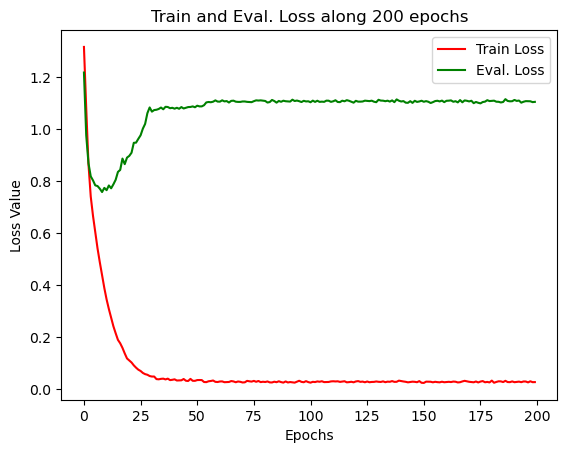

In [22]:
import matplotlib.pyplot as plt

epoch = len(epochs)

plt.plot(epochs, train_loss_hist, color='r', label='Train Loss')
plt.plot(epochs, val_loss_hist, color='g', label='Eval. Loss')


plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.title(f"Train and Eval. Loss along {epoch} epochs")

plt.legend()

plt.show()

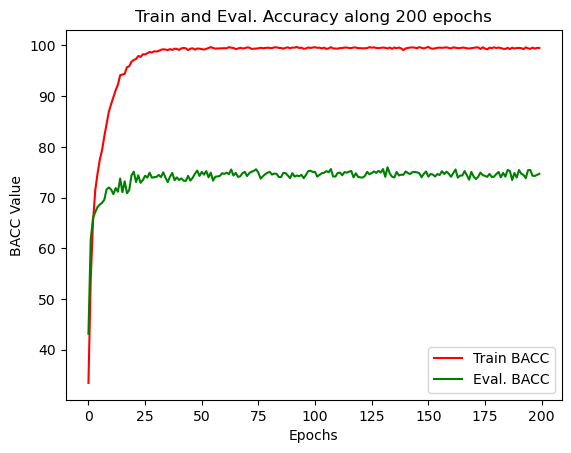

In [23]:
plt.plot(epochs, train_wa_hist, color='r', label='Train BACC')
plt.plot(epochs, val_wa_hist, color='g', label='Eval. BACC')


plt.xlabel("Epochs")
plt.ylabel("BACC Value")
plt.title(f"Train and Eval. Accuracy along {epoch} epochs")

plt.legend()

plt.show()